In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

os.chdir('./OCTA_CycleGAN/CycleSR/')

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1-uRJf7DyoYViOmhG7IAGK6e9APkOhT7D/Colab Notebooks


In [2]:
!pip install --upgrade pip
!pip uninstall scikit-image
!pip install scikit-image
import skimage
print(skimage.__version__)

     |████████████████████████████████| 1.7 MB 14.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Found existing installation: scikit-image 0.18.3
Uninstalling scikit-image-0.18.3:
  Would remove:
    /usr/local/bin/skivi
    /usr/local/lib/python3.7/dist-packages/scikit_image-0.18.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_image.libs/libgomp-3300acd3.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/skimage/*
Proceed (Y/n)? y
  Successfully uninstalled scikit-image-0.18.3
     |████████████████████████████████| 13.3 MB 13.8 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
0.19.1


In [3]:
%cd ./pytorch_wavelets/
!pip install .
%cd ../

/content/drive/.shortcut-targets-by-id/1-uRJf7DyoYViOmhG7IAGK6e9APkOhT7D/Colab Notebooks/OCTA_CycleGAN/CycleSR/pytorch_wavelets
Processing /content/drive/.shortcut-targets-by-id/1-uRJf7DyoYViOmhG7IAGK6e9APkOhT7D/Colab Notebooks/OCTA_CycleGAN/CycleSR/pytorch_wavelets
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.3.0-py3-none-any.whl size=55125 sha256=f9310824b7284842f65521e0f30baf720e9e74647f7bc5171e0f0e1cbc984897
  Stored in directory: /tmp/pip-ephem-wheel-cache-ne6gwlbi/wheels/ca/39/50/a6e135c109deb8e6fc23e5e2a43a3f61fc21623f434cece937
Successfully built pytorch-wavelets
/content/drive/.shortcut-targets-by-id/1-uRJf7DyoYViOmhG7IAGK6e9APkOhT7D/Colab Notebooks/OCTA_CycleGAN/CycleSR


In [6]:
!python train.py --decay_epoch 30 --pretrained True

Namespace(batchSize=1, cuda=False, dataroot='./dataset/Colab_random_OCTA_augmented', decay_epoch=30, epoch=0, input_nc=1, lr=0.00013, n_cpu=2, n_epochs=50, output_nc=1, pretrained=True, pretrained_root='./pre_trained/netG_A2B_pretrained.pth', sizeA=128, sizeB=256)
# FS type: gau, kernel size=5
# FS type: gau, kernel size=5
Adjusting learning rate of group 0 to 1.3000e-04.
Adjusting learning rate of group 0 to 1.3000e-04.
354
[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
Adjusting learning rate of group 0 to 1.3000e-04.
Adjusting learning rate of group 0 to 1.3000e-04.
Epoch (1/50) Finished
100% 297/297 [05:26<00:00,  1.10s/it]
 PSNR: 16.5977 SSIM: 0.4101 MSE: 0.0882 NMI: 1.0515
Adjusting learning rate of group 0 to 1.3000e-04.
Adjusting learning rate of group 0 to 1.3000e-04.
Epoch (2/50) Finished
100% 297/297 [00:26<00:00, 11.41it/s]
 PSNR: 17.2402 SSIM: 0.4391 MSE: 0.0762 NMI: 1.0552
Adjusting learning rate of group 0 to 1.

In [73]:
from model import UnetGeneratorA2B
import torch
import glob
import random
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [74]:
class Test_ImageDataset(Dataset):
    def __init__(self, root, transforms_test=None, unaligned=False, mode='test'):
        self.transformA = transforms.Compose(transforms_test)
        self.transformB = transforms.Compose(transforms_test)

        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '6x6_256/') + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '3x3_256/') + '/*.*'))

    def __getitem__(self, index):
        img_A = Image.open(self.files_A[index % len(self.files_A)]).convert('L')
        print(self.files_A[index % len(self.files_A)])
        item_A = self.transformA(img_A)

        item_B = self.transformB(Image.open("./dataset/test/3x3_256/102_6.png").convert('L'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

test_path = "./dataset/test/"
transforms_test = [ 
                transforms.ToTensor(),
                # transforms.Normalize((0.246), (0.170)),
                transforms.Normalize((0.5), (0.5)) ]
test_dataset = Test_ImageDataset(test_path, transforms_test=transforms_test, unaligned=True)

In [85]:
img = test_dataset[2]['A']
gt = test_dataset[2]['B']
print(img.shape)
img = cv2.resize(img.squeeze(0).cpu().numpy(), dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
x = torch.tensor(img).unsqueeze(0).unsqueeze(0).cuda()


netG_A2B = UnetGeneratorA2B(1, 1).cuda()
model = torch.load("./output_exp/netG_A2B_epoch41.pth")
netG_A2B.load_state_dict(model, strict=False)
_, _, y = netG_A2B(x)

./dataset/test/6x6_256/102_3.png
./dataset/test/6x6_256/102_3.png
torch.Size([1, 256, 256])


(-0.5, 127.5, 127.5, -0.5)

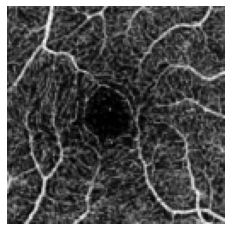

In [86]:
plt.imshow(img, "gray")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

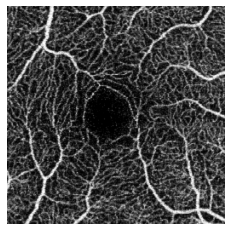

In [87]:
plt.imshow(gt.squeeze(0), "gray")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

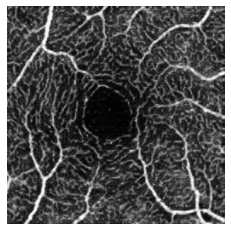

In [88]:
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(yimg, "gray")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

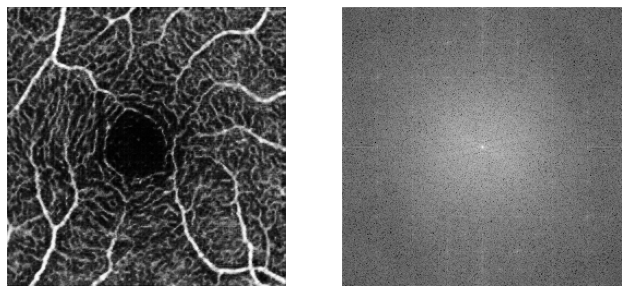

In [89]:
f = np.fft.fft2(yimg, axes=(-2, -1))
fshift = np.fft.fftshift(f)
res = np.log(np.abs(fshift))
pha = np.angle(fshift)
plt.figure(figsize=(11, 11))
plt.subplot(121), plt.imshow(yimg, 'gray')
plt.axis('off')
plt.subplot(122), plt.imshow(res, 'gray')
plt.axis('off')